In [ ]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
from skimage import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas import ExcelWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pandas as pd
from skimage.measure import shannon_entropy
import pickle
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#Training Set
'''image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TrainingSet/"
EX_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/HardExudates/"
SE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/SoftExudates/"
candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/Exudates/"

images = os.listdir(image_path)
EX_masks = os.listdir(EX_mask_path)
SE_masks = os.listdir(SE_mask_path)

images.sort()
EX_masks.sort()
SE_masks.sort()
'''
scaler_filename = "/content/drive/MyDrive/DRsegmentation/IP_ML/Training/EX_scaler.save"

#Test
image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TestingSet/"
EX_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/HardExudates/"
SE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/SoftExudates/"
candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/TestSet/Exudates/"

images = os.listdir(image_path)
EX_masks = os.listdir(EX_mask_path)
SE_masks = os.listdir(SE_mask_path)

images.sort()
EX_masks.sort()
SE_masks.sort()



In [ ]:
def rgb2Gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return  cl1

def adjust_gamma(image, gamma=1.0):
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
   return cv2.LUT(image, table)

def OTSU(img_gray):
    max_g = 0
    suitable_th = 0
    th_begin = 0
    th_end = 256
    for threshold in range(th_begin, th_end):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue
 
        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
 
    return suitable_th


def vessel(img):
    dst = 255 - img
    clahe = cv2.createCLAHE(clipLimit=0.18,tileGridSize=(1,1))
    Ien = clahe.apply(dst)  
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    final = cv2.subtract(Ien,opening)
    test =  OTSU(final)
    ret , binary = cv2.threshold (final ,test, test, cv2.THRESH_BINARY) 
    binary = cv2.medianBlur(binary, 3) 
    #binary = cv2.blur(binary,(5,5))
    return binary


def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    #TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    #FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    #TPR = TP/(FN + TP)
    #TNR = TN/(TN + FP)
    #P = TP/(TP + FP)
    R=0
    if (TP+FN) !=0: 
      R = TP/(TP + FN)
    #JSC = TP/(TP + FP + FN)
    #DSC = 2*(TP/(FP + 2*TP + FN))
    return R



def feature_extractor(region):
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        ################################################################
        #START ADDING DATA TO THE DATAFRAME
  
                
        #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(region, [1], [0])       
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(region, [3], [0])       
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2       
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2       
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2       
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(region, [5], [0])       
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3       
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3       
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3       
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3

        GLCM4 = greycomatrix(region, [0], [np.pi/4])       
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4       
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4       
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4       
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4
        
        GLCM5 = greycomatrix(region, [0], [np.pi/2])       
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5       
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5       
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5       
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5
        
        #Add more filters as needed
        entropy = shannon_entropy(region)
        df['Entropy'] = entropy

        
        #Append features from current image to the dataset
        #image_dataset = image_dataset.append(df)
        
        return df
        
def candidates_selection(rimg,im_mask_ex,im_mask_se):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    t_features = pd.DataFrame()
    t_labels = [] 
    print(len(contours))
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        roi=rimg[y:y+h,x:x+w]
        cv2.rectangle(originalImage,(x,y),(x+w,y+h),(0,255,255),5)
        regions_img=rimg[y:y+h, x:x+w]
        regions_ex=im_mask_ex[y:y+h, x:x+w]
        regions_se=im_mask_se[y:y+h, x:x+w]
        S_ex = evaluation(regions_img, regions_ex)
        S_se = evaluation(regions_img, regions_se)
        t_features=t_features.append(feature_extractor(cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)))
        if (S_ex > 0.1) and (S_ex >= S_se):
           t_labels.append(1)
        elif (S_se>0.1) and (S_se >= S_ex):
          t_labels.append(2)
        else:
          t_labels.append(0)

    return t_features, t_labels

def candidates_extraction_for_inference(mymodel,imgorginal,rimg):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    region_features = [] 
    preds0=[]
    preds1=[]
    ex_segmented_img = np.zeros((imgorginal.shape[0],imgorginal.shape[1])) 
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        region_features = pd.DataFrame()
        region_features=feature_extractor(cv2.cvtColor(imgorginal[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY))
        scaler = joblib.load(scaler_filename) 
        features=scaler.transform(region_features.values)
        pred= mymodel.predict(features)
        if pred[0]==1:
          preds0.append(pred[0])
          ex_segmented_img[y:y+h, x:x+w] = rimg[y:y+h, x:x+w]
    return preds0, preds1, ex_segmented_img

def plot(myimg,mtype="gray"):
  if mtype=="gray":
    plt.imshow(myimg,cmap= mtype)
  else:
    plt.imshow(cv2.cvtColor(myimg, cv2.COLOR_BGR2RGB))
  plt.show()

def train(classifier,X_train,y_train):
    if classifier=='LGBM':
        #Class names for LGBM start at 0 so reassigning labels from 1,2,3,4 to 0,1,2,3
        d_train = lgb.Dataset(X_train, label=y_train)

        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
                       'objective':'multiclass',
                       'metric': 'multi_logloss',
                       'num_leaves':100,
                       'max_depth':10,
                       'num_class':3}  #no.of unique values in the target class not inclusive of the end value
        my_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates
    elif  classifier=='RF':
        my_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
        my_model.fit(X_train, y_train) 
    elif classifier=='SVM':
        #my_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
        #my_model.fit(X_train, y_train)
        my_model = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
        #my_model = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

    return my_model

def predict(mymodel,X_test,y_test):
  test_prediction = mymodel.predict(X_test)
  test_pred = (test_prediction >= 0.5)
  acc=metrics.accuracy_score(y_test, test_pred)
  df = pd.DataFrame()
  y_test = np.array(y_test)
  y_test = y_test.flatten()
  df['y_test'] = y_test
  df['test_pred'] = test_pred
  writer = ExcelWriter('/content/drive/MyDrive/DRsegmentation/IP_ML/Training/acc_exudates_test.xlsx')
  df.to_excel(writer,'Sheet5')
  writer.save()
  return acc,test_pred

#Print confusion matrix
def CM_plot(y_test, test_pred):
    cm = confusion_matrix(y_test, test_pred)
    fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
    sns.set(font_scale=1.6)
    sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

def extract_Exudates(img):
    gray  = rgb2Gray(img)
    T, B_Fov = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    b,g,r = cv2.split(img)
    Ienhance = clahe_equalized(g)
    Ienhance =adjust_gamma((255-Ienhance),gamma=1)
    plt.imshow(Ienhance,"gray")
    plt.show()

    Imedfilter = cv2.medianBlur(Ienhance,81)
    Isub = cv2.subtract(Imedfilter,Ienhance)
    Isub_filter = cv2.blur(Isub,(5,5))
    Isub_filter = cv2.bitwise_and(Isub,B_Fov)
    bestTh = OTSU(Isub_filter)
    T,Idark_tep = cv2.threshold(Isub_filter, bestTh, 255, cv2.THRESH_BINARY)
    sOP = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    Bdark = cv2.morphologyEx(Idark_tep,cv2.MORPH_OPEN,sOP)

    Imed = cv2.medianBlur(Ienhance,131)
    Isub1 = cv2.subtract(Imed,Ienhance)
    Isub_filter1 = cv2.blur(Isub1,(5,5))
    bestTh1 =  OTSU(Isub_filter1)
    T,Idark_tep1 = cv2.threshold(Isub_filter1, bestTh1, 255, cv2.THRESH_BINARY)
    Bdark1 = cv2.morphologyEx(Idark_tep1,cv2.MORPH_OPEN,sOP)

    Bduel = cv2.bitwise_or(Bdark,Bdark1)

    Ismooth = cv2.GaussianBlur(Ienhance,(7,7),0)
    Ivessel = vessel(Ismooth)
    kernel = np.ones((5, 5), np.uint8)
    Ivessel = cv2.dilate(Ivessel, kernel)

    Bduel = cv2.erode(Bduel,kernel)
    same = cv2.bitwise_and(Ivessel,Bduel)
    result = cv2.subtract(Bduel,same)
    sOP6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    result = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP6)
    result = cv2.erode(result,kernel)

    sOP10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    result1 = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP10)

    result = cv2.bitwise_or(result,result1)
    result =  cv2.dilate(result, kernel)
    return result

def segment(original_img,segmented_img):
  #
  rf=candidates_extraction_for_inference(mymodel,original_img,segmented_img)

  return rf

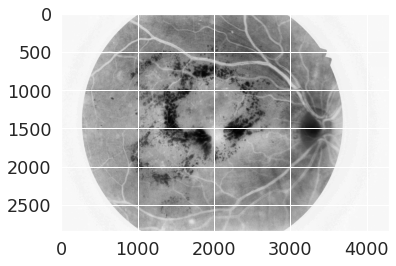

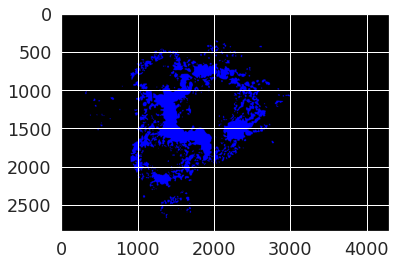

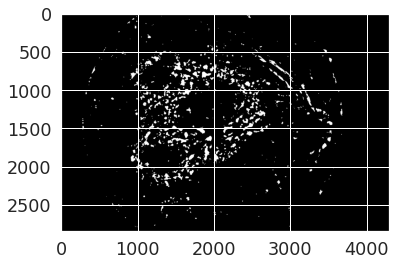

260
0


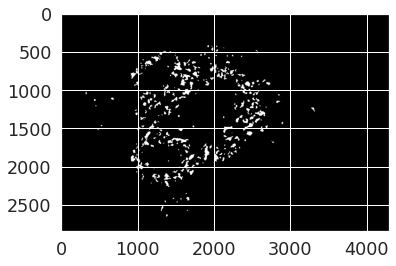

0.3054043622185296


In [ ]:
#original_img= cv2.imread('/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TestingSet/IDRiD_72.jpg')

#segmented_img=extract_Exudates(original_img)

num=11
image = image_path + images[num]
ex_mask = EX_mask_path + EX_masks[num]
se_mask = SE_mask_path + SE_masks[num]
img = cv2.imread(image)
mask_ex = cv2.imread(ex_mask)
mask_se = cv2.imread(se_mask)
segmented_img=extract_Exudates(img)
plot(mask_ex)
plot(segmented_img)
x0,x1, ex_segmented_img=segment(img,segmented_img)
mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
ret,mask_ex = cv2.threshold(mask_ex,10,255,cv2.THRESH_BINARY)
#plot(img,"rbg")

print(len(x0))
print(len(x1))
plot(ex_segmented_img)

print(evaluation(ex_segmented_img,mask_ex))

0 : OriginalImage


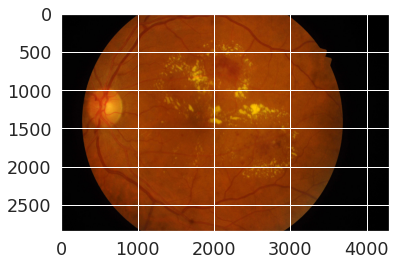

0 : mask


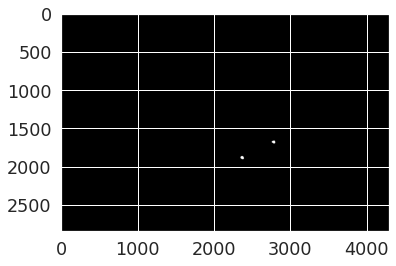

0 : mask


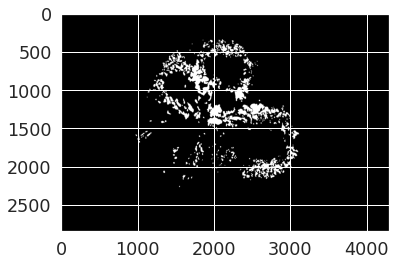

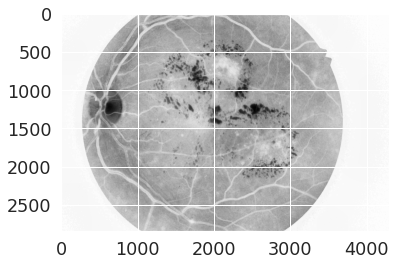

0 : lesions_segmented


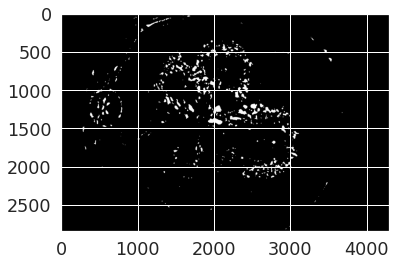

467
1 : OriginalImage


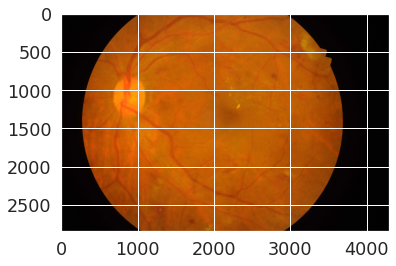

1 : mask


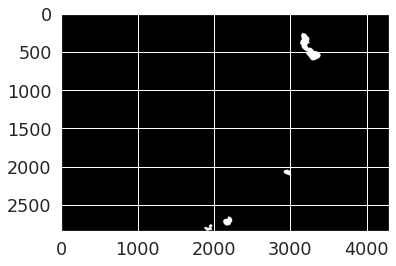

1 : mask


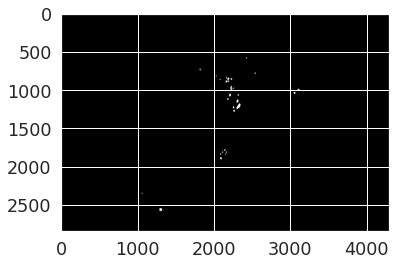

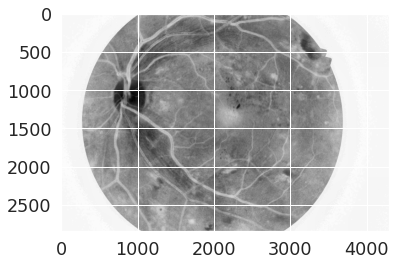

1 : lesions_segmented


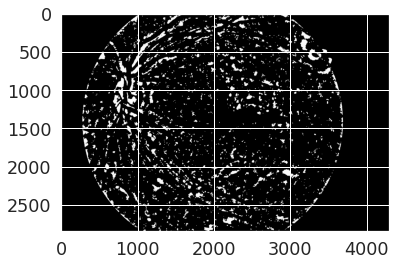

1948
2 : OriginalImage


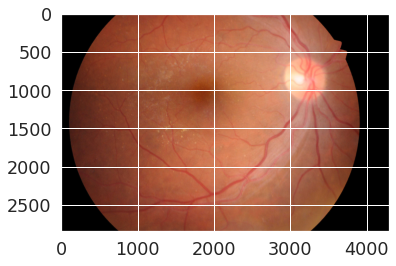

2 : mask


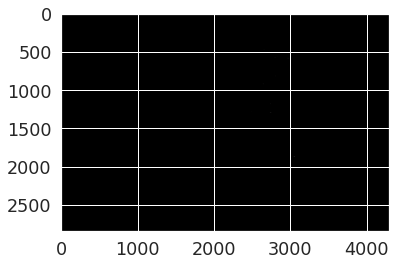

2 : mask


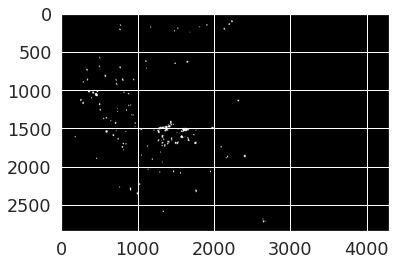

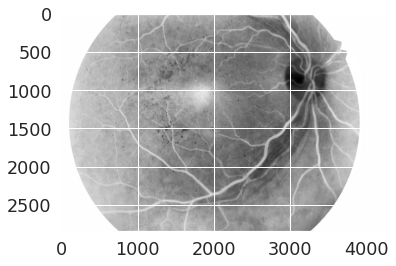

2 : lesions_segmented


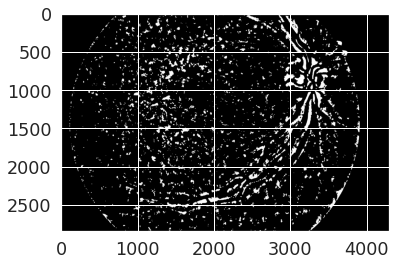

2103
3 : OriginalImage


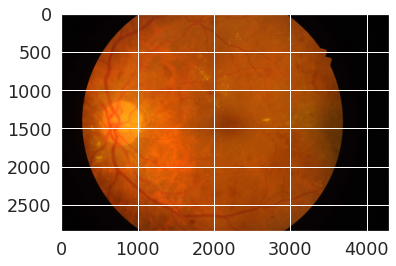

3 : mask


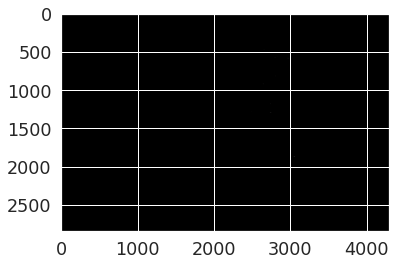

3 : mask


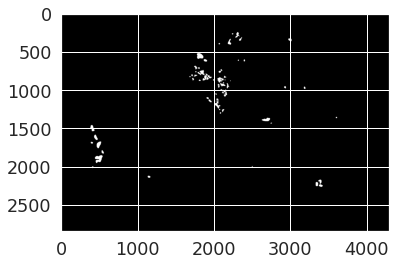

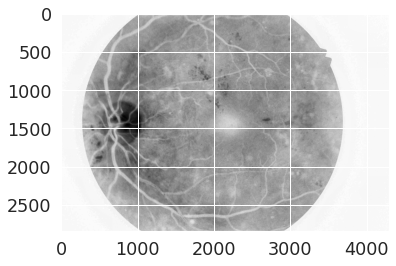

3 : lesions_segmented


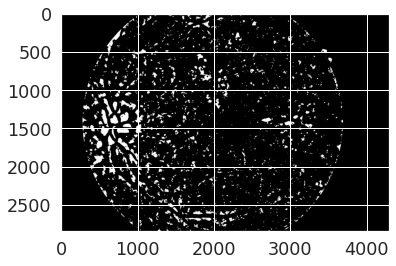

1792
4 : OriginalImage


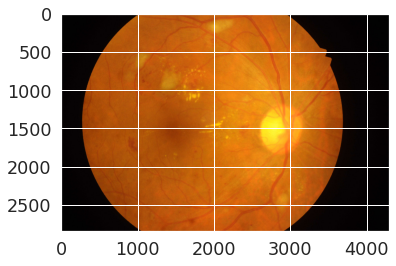

4 : mask


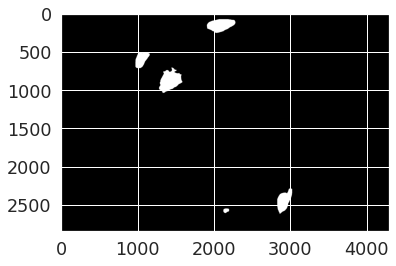

4 : mask


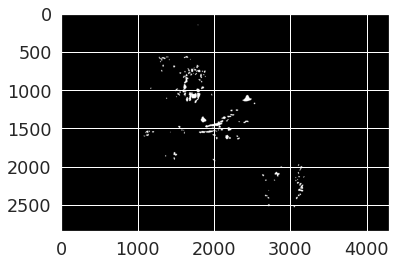

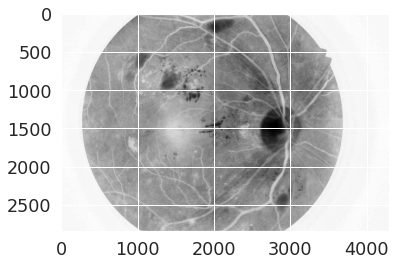

4 : lesions_segmented


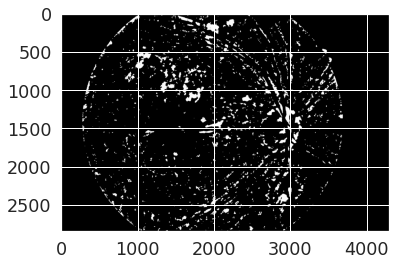

1495
5 : OriginalImage


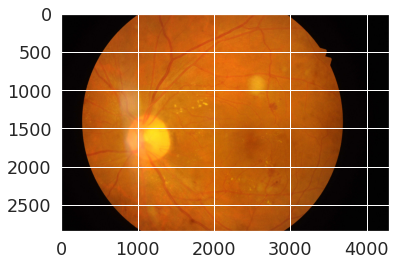

5 : mask


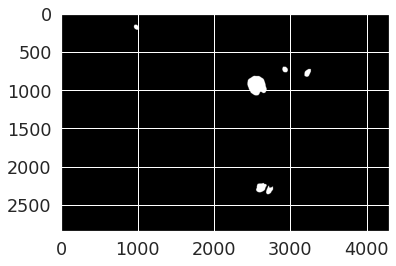

5 : mask


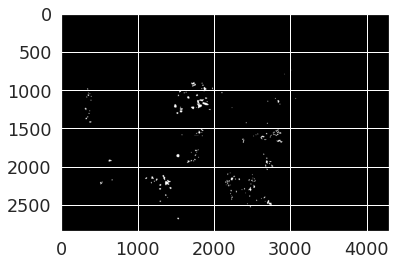

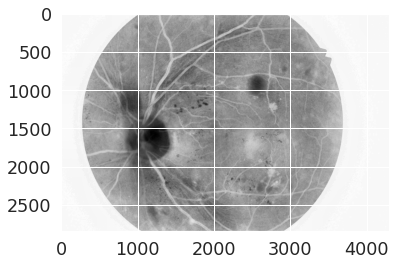

5 : lesions_segmented


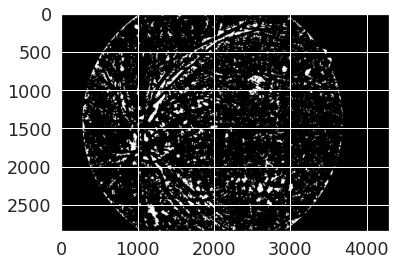

2253
6 : OriginalImage


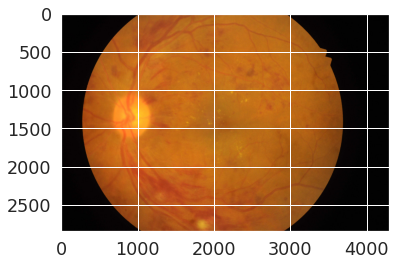

6 : mask


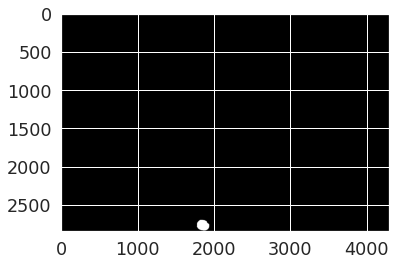

6 : mask


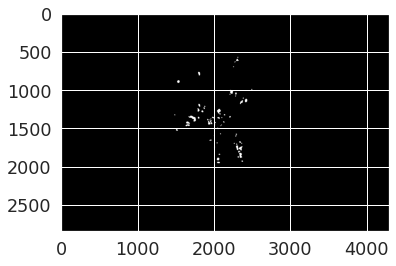

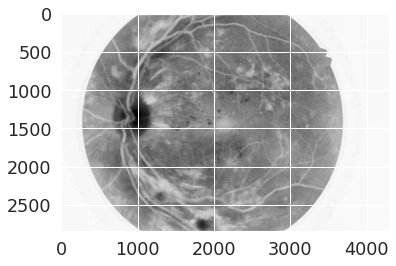

6 : lesions_segmented


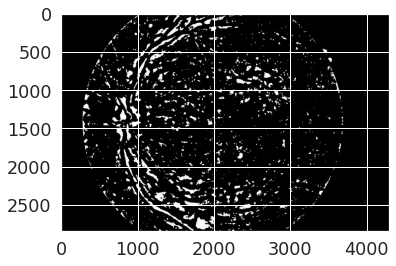

1465
7 : OriginalImage


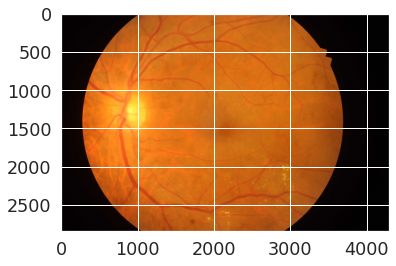

7 : mask


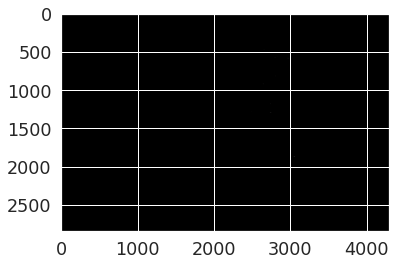

7 : mask


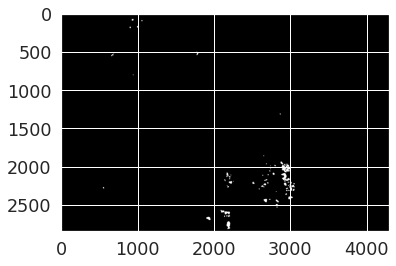

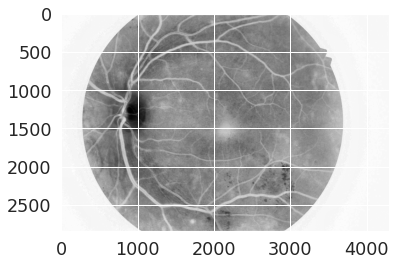

7 : lesions_segmented


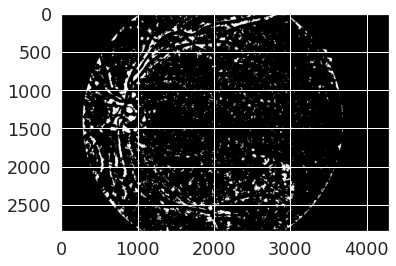

1570
8 : OriginalImage


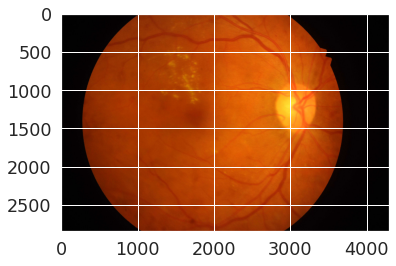

8 : mask


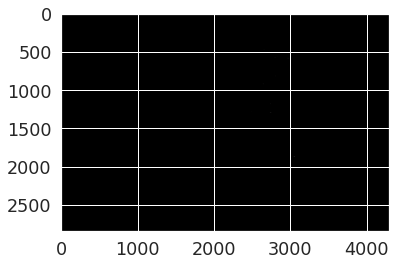

8 : mask


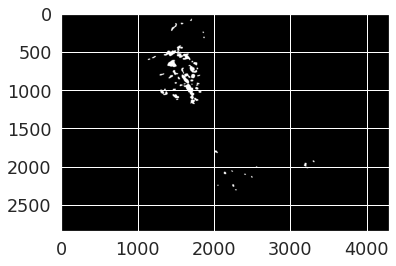

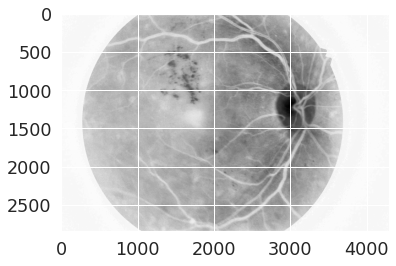

8 : lesions_segmented


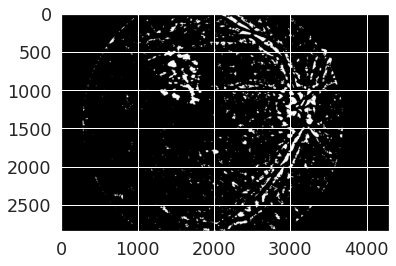

1022
9 : OriginalImage


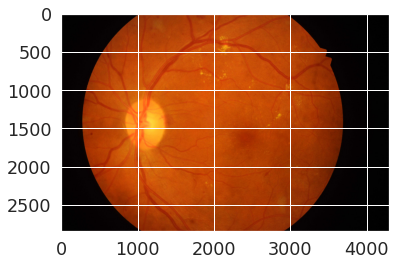

9 : mask


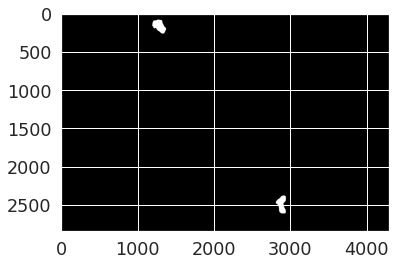

9 : mask


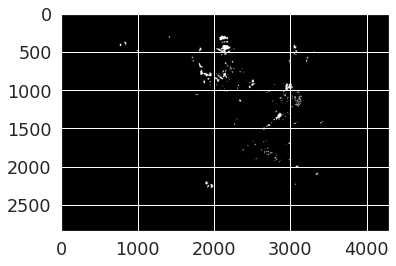

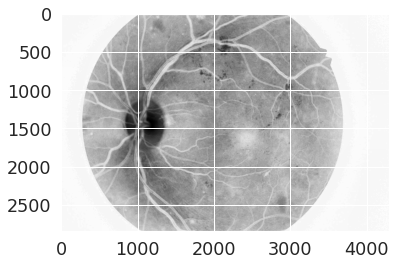

9 : lesions_segmented


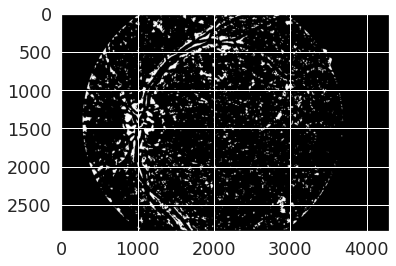

1815
10 : OriginalImage


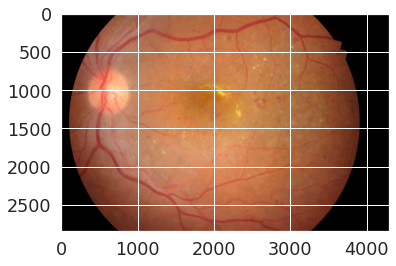

10 : mask


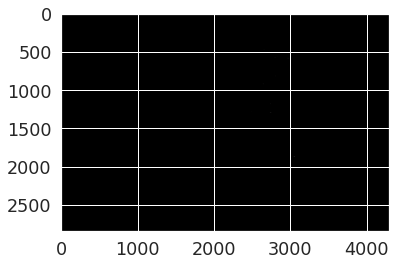

10 : mask


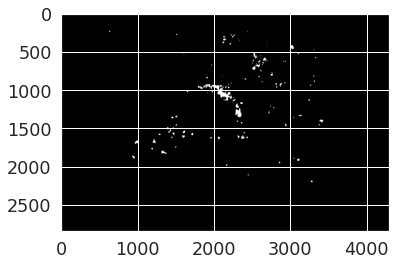

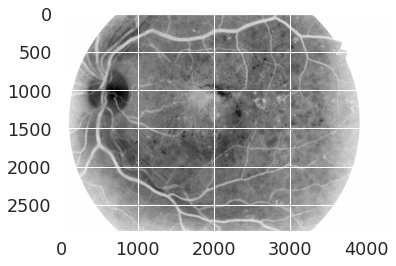

10 : lesions_segmented


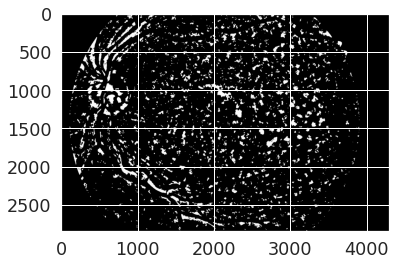

2077
11 : OriginalImage


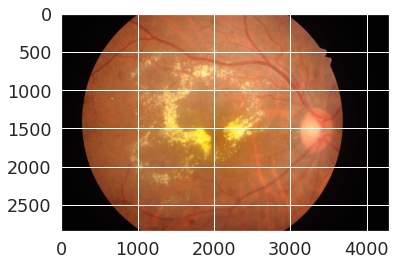

11 : mask


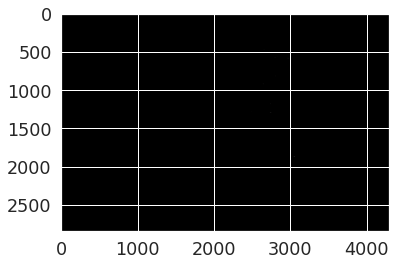

11 : mask


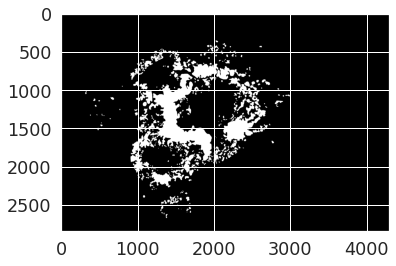

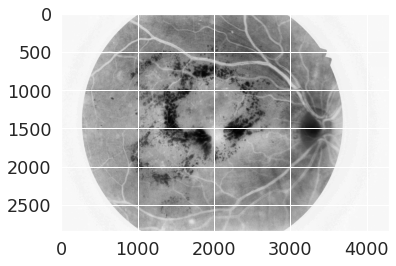

11 : lesions_segmented


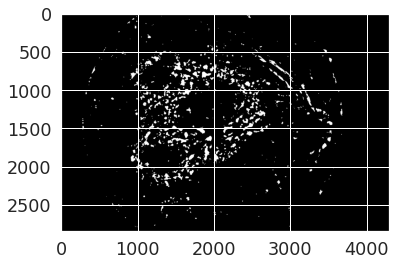

763
12 : OriginalImage


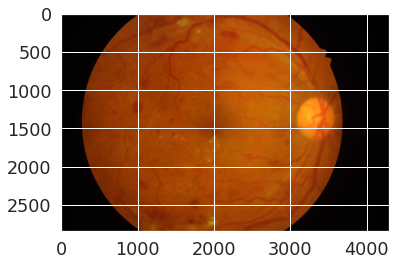

12 : mask


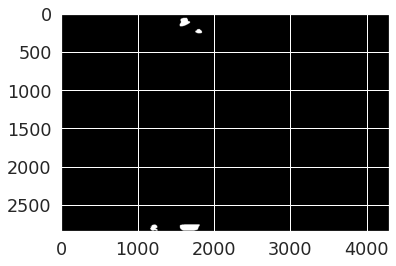

12 : mask


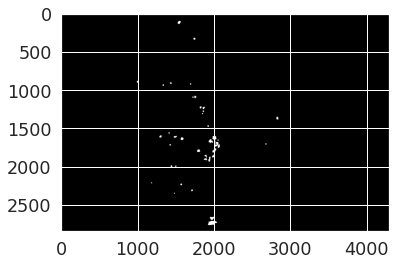

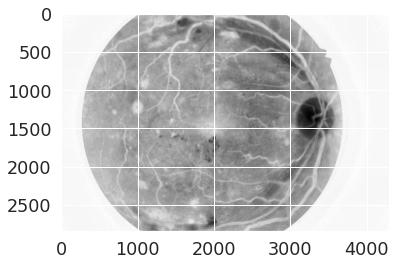

12 : lesions_segmented


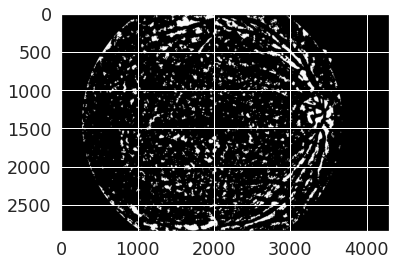

1765
13 : OriginalImage


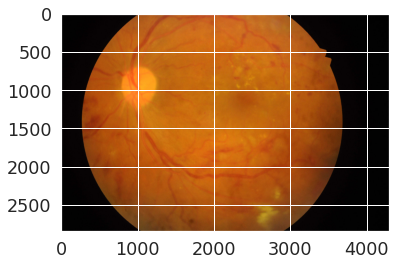

13 : mask


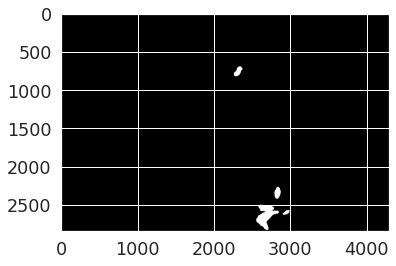

13 : mask


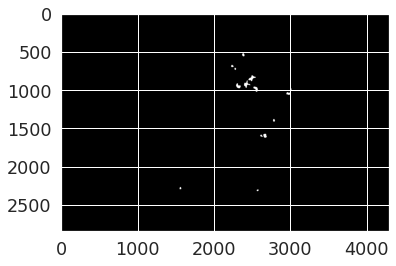

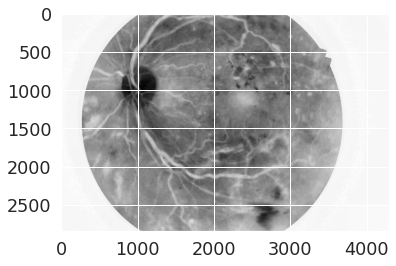

13 : lesions_segmented


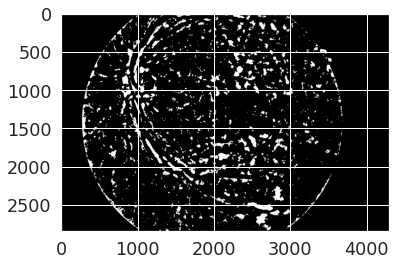

1448
14 : OriginalImage


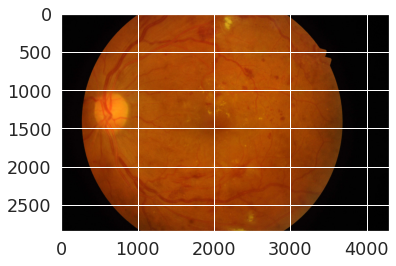

14 : mask


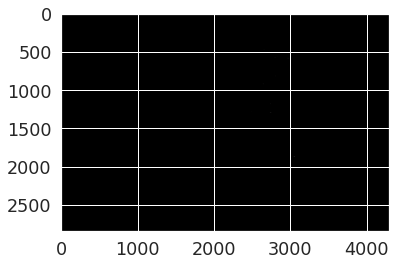

14 : mask


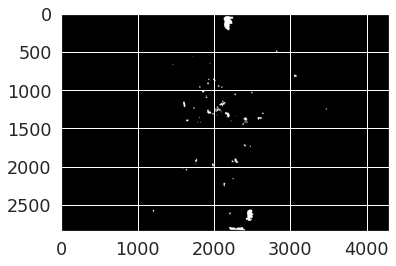

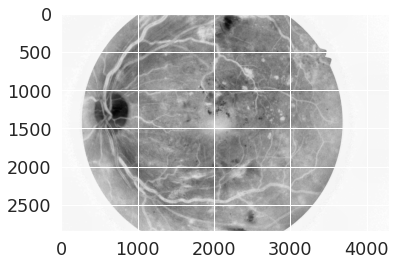

14 : lesions_segmented


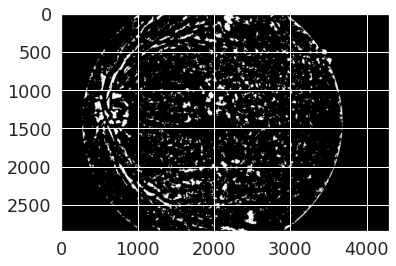

1790
15 : OriginalImage


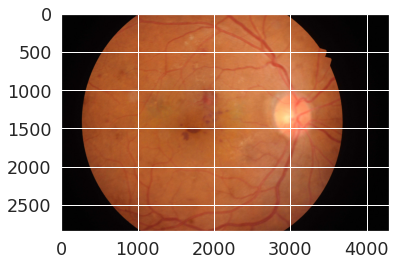

15 : mask


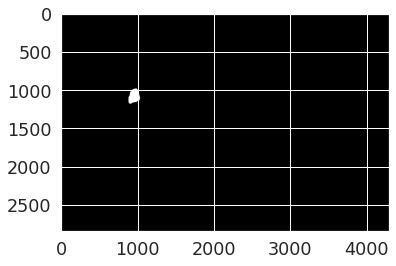

15 : mask


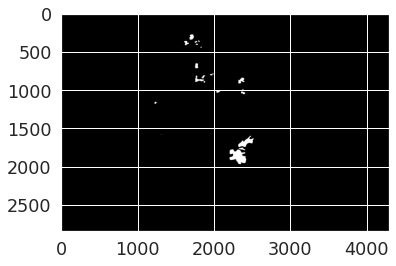

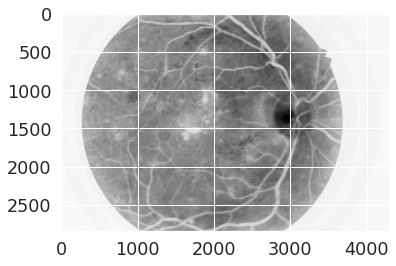

15 : lesions_segmented


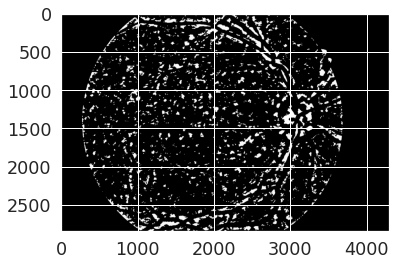

1824
16 : OriginalImage


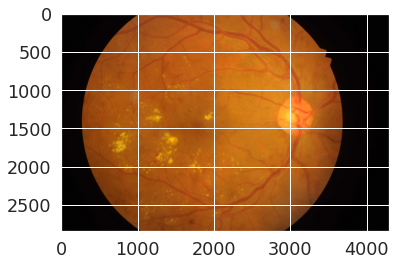

16 : mask


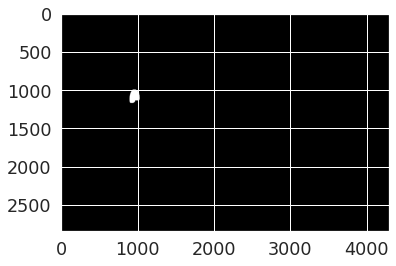

16 : mask


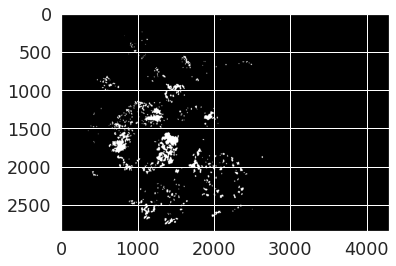

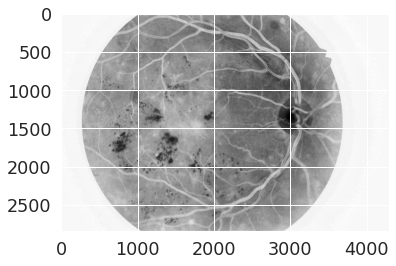

16 : lesions_segmented


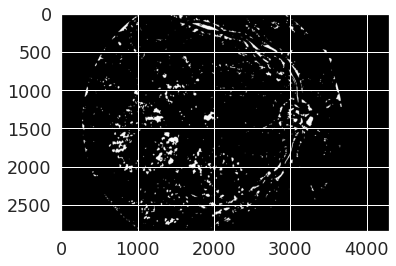

910
17 : OriginalImage


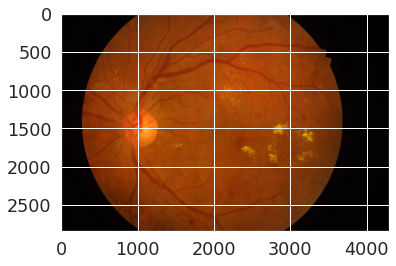

17 : mask


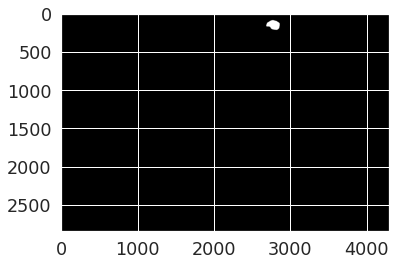

17 : mask


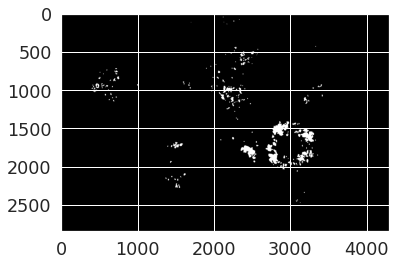

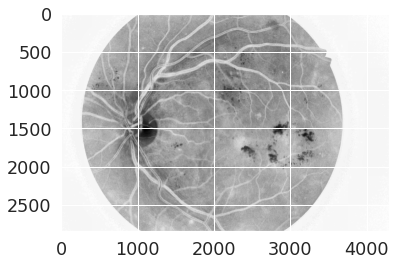

17 : lesions_segmented


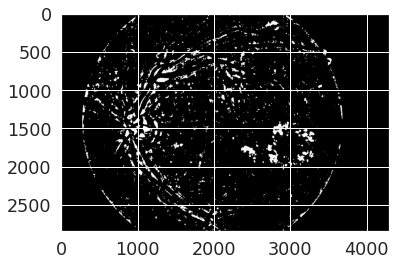

1354
18 : OriginalImage


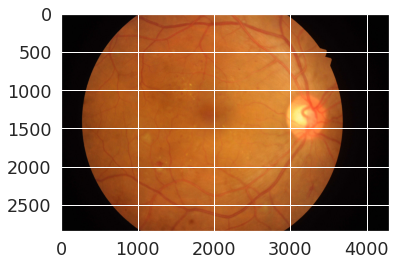

18 : mask


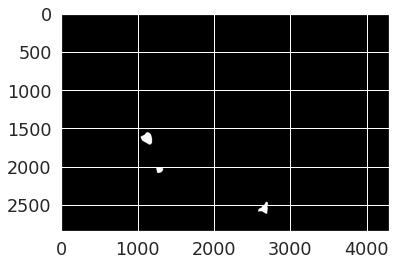

18 : mask


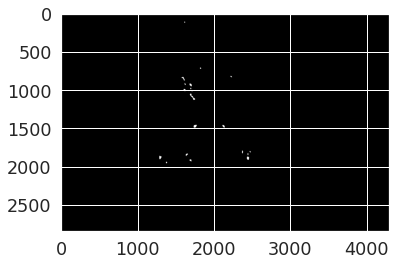

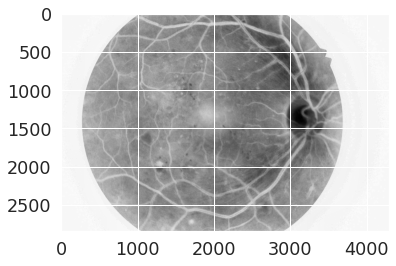

18 : lesions_segmented


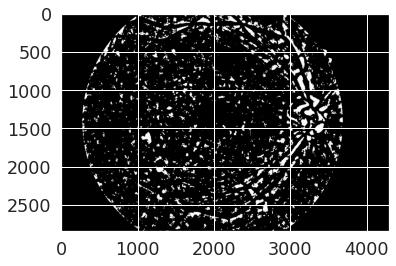

1826
19 : OriginalImage


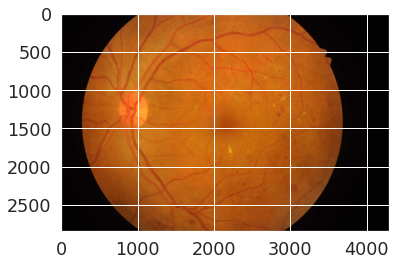

19 : mask


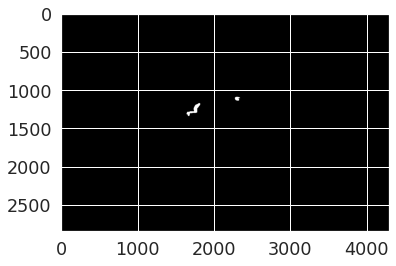

19 : mask


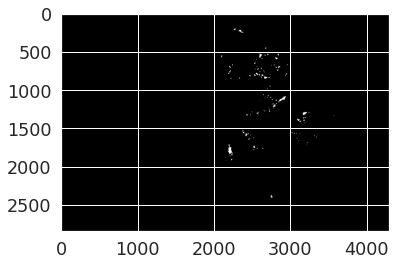

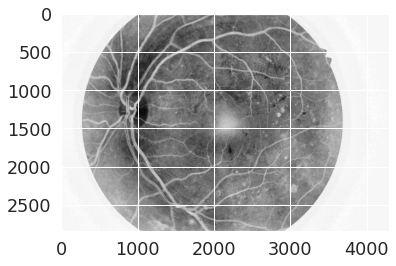

19 : lesions_segmented


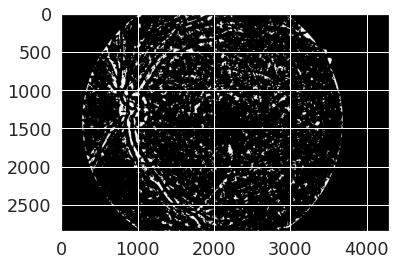

1967
20 : OriginalImage


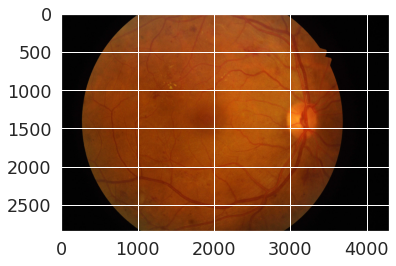

20 : mask


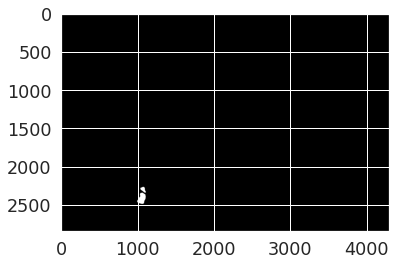

20 : mask


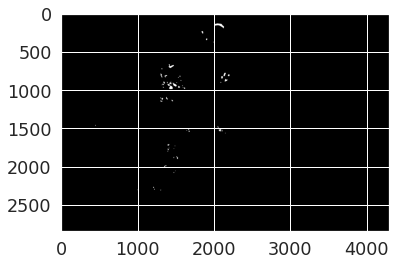

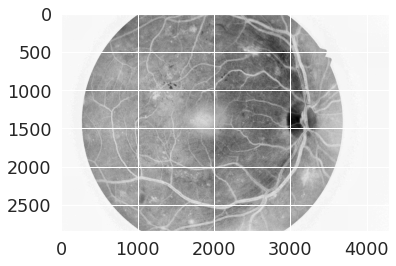

20 : lesions_segmented


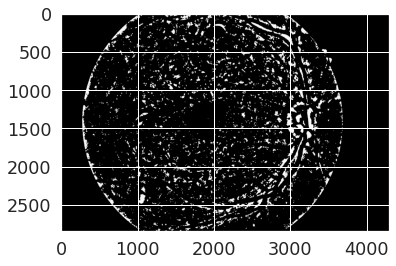

2351
21 : OriginalImage


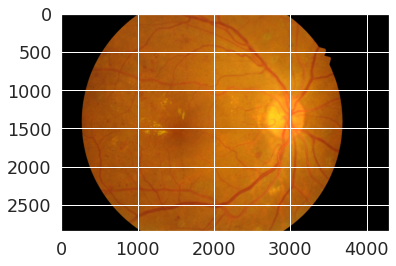

21 : mask


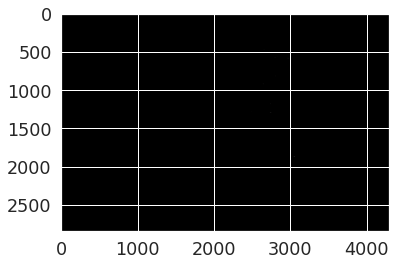

21 : mask


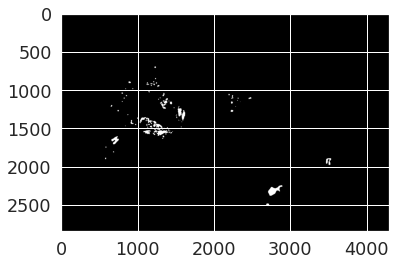

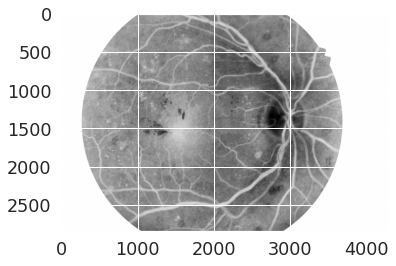

21 : lesions_segmented


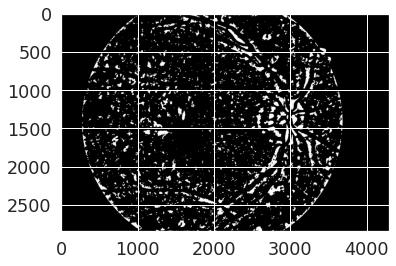

1902
22 : OriginalImage


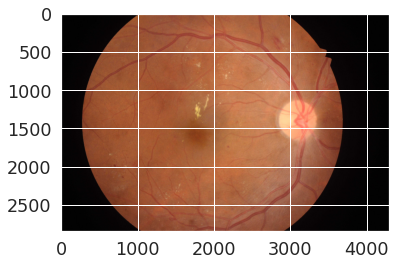

22 : mask


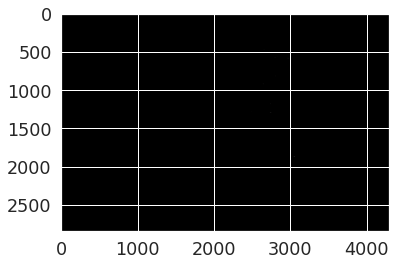

22 : mask


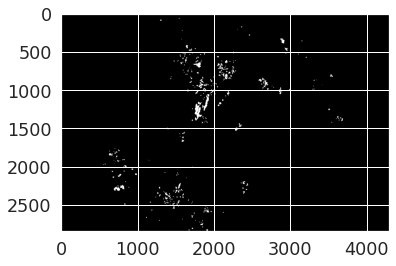

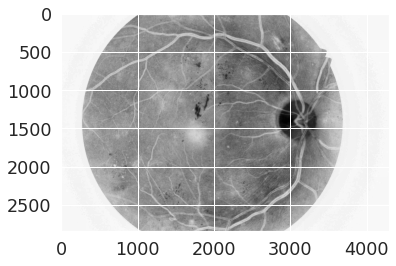

22 : lesions_segmented


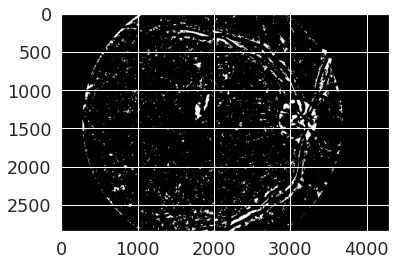

1713
23 : OriginalImage


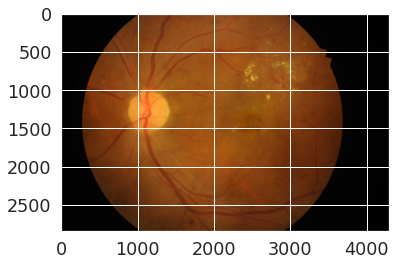

23 : mask


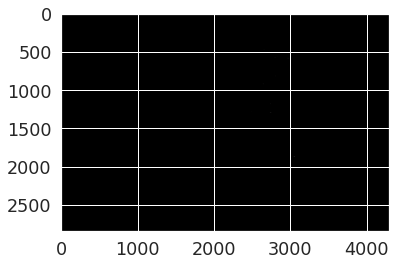

23 : mask


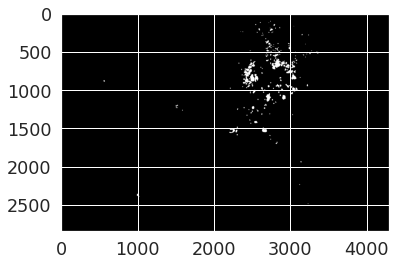

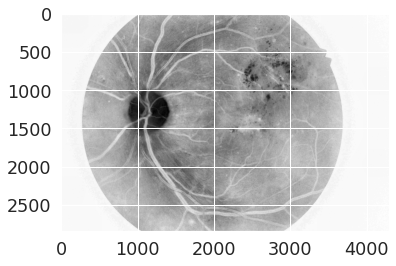

23 : lesions_segmented


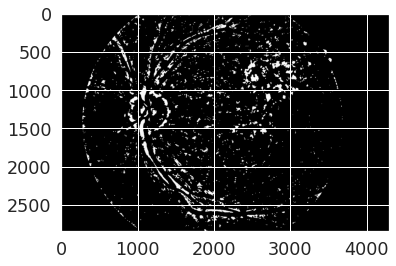

1574
24 : OriginalImage


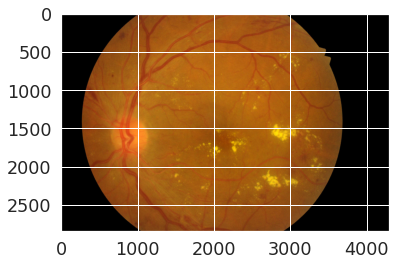

24 : mask


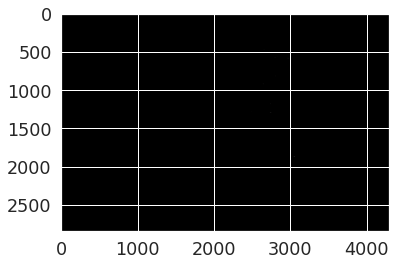

24 : mask


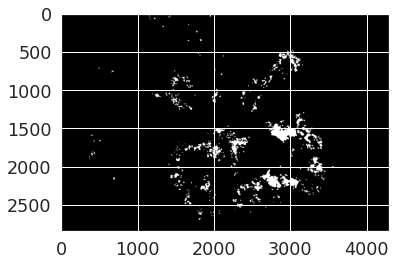

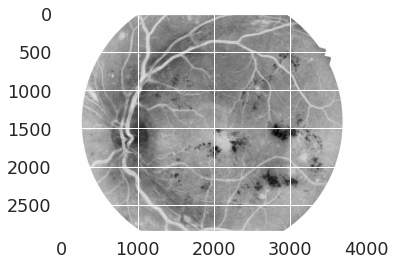

24 : lesions_segmented


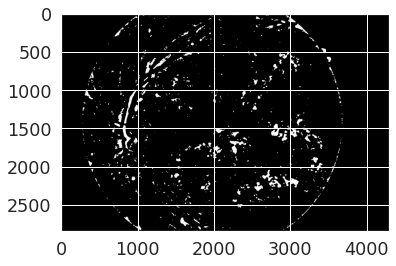

812
25 : OriginalImage


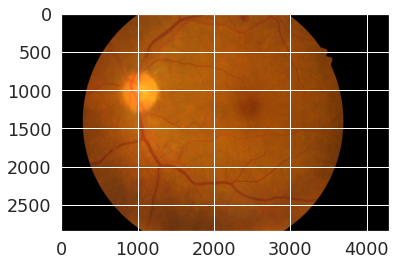

25 : mask


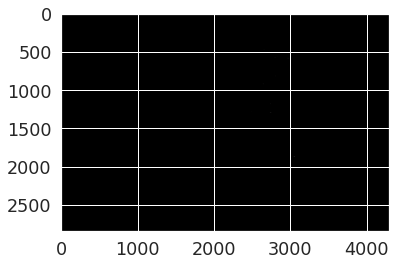

25 : mask


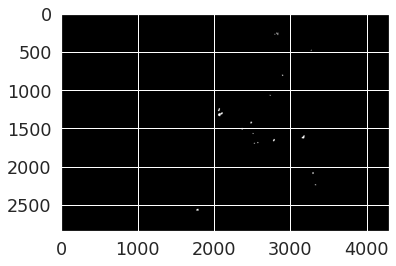

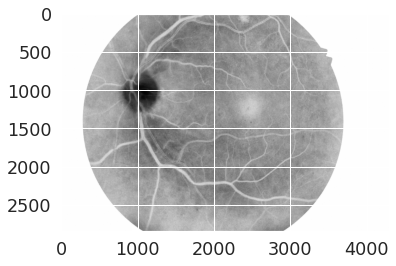

25 : lesions_segmented


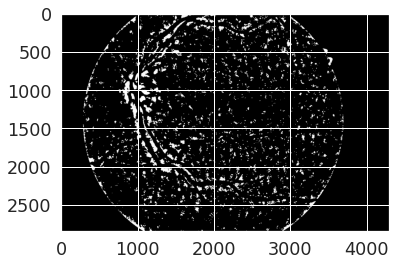

2365
26 : OriginalImage


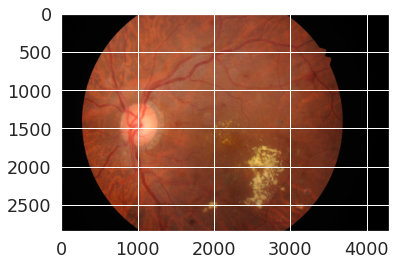

26 : mask


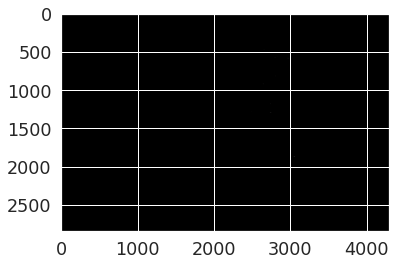

26 : mask


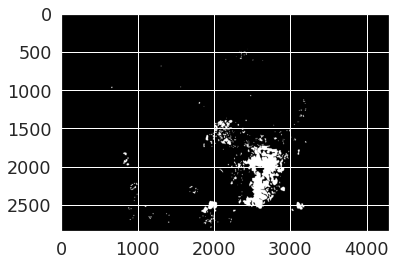

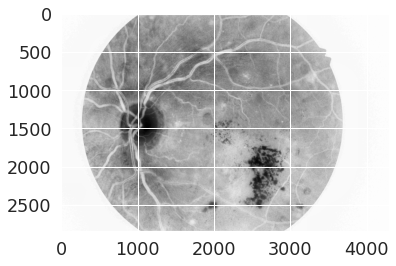

26 : lesions_segmented


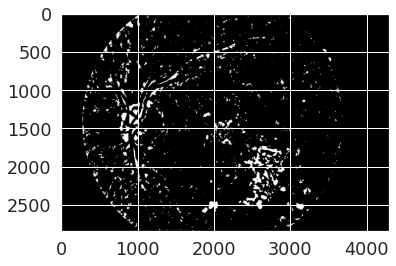

1131


In [ ]:
train_features = pd.DataFrame()
train_labels = [] 

for img_number in range(len(images)):
    # Read Image and Mask
    image = image_path + images[img_number]
    ex_mask = EX_mask_path + EX_masks[img_number]
    se_mask = SE_mask_path + SE_masks[img_number]
    img = cv2.imread(image)
    mask_ex = cv2.imread(ex_mask)
    mask_se = cv2.imread(se_mask)
    originalImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img_number,": OriginalImage")
    plot(originalImage,"BrBG")
    #Load the mask
    im_mask_se = cv2.cvtColor(mask_se, cv2.COLOR_BGR2GRAY)
    th, im_mask_se = cv2.threshold(im_mask_se, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_se)
    im_mask_ex = cv2.cvtColor(mask_ex, cv2.COLOR_BGR2GRAY)
    th, im_mask_ex = cv2.threshold(im_mask_ex, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ex)
    # segment the hard exudates
    lesions_segmented = extract_Exudates(img)
    print(img_number,": lesions_segmented")
    plot(lesions_segmented)
    cv2.imwrite(candidates_path + images[img_number], lesions_segmented)
    # Get the candidates & their GLCM features with lables 
    lesions_segmented = lesions_segmented.astype(np.uint8)
    t_features, t_labels = candidates_selection(lesions_segmented,im_mask_ex,im_mask_se)
    train_features=train_features.append(t_features)
    train_labels.append(t_labels)


In [ ]:
# Save Training set TO EXCEL
train_data = pd.DataFrame()
ls=[]
for i in range(len(train_labels)):
  for j in range(len(train_labels[i])):
    ls.append(train_labels[i][j])
m = np.asarray(ls)

tdata = pd.DataFrame(train_features)
tdata['Lable'] = m
writer = ExcelWriter('/content/drive/MyDrive/DRsegmentation/IP_ML/Training/TestingSet_Exudates.xlsx')
tdata.to_excel(writer,'Sheet1')
writer.save()


In [ ]:
#d_features=d_features.drop(index=0)
#
train_features = pd.read_excel("/content/drive/MyDrive/DRsegmentation/IP_ML/Training/TrainingSet_Exudates.xlsx")
m=train_features['Lable']
train_features=train_features.drop(columns="Lable")
train_features = train_features.iloc[: , 1:]

#print(train_features.head())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:230: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy =  0.9522526706920575


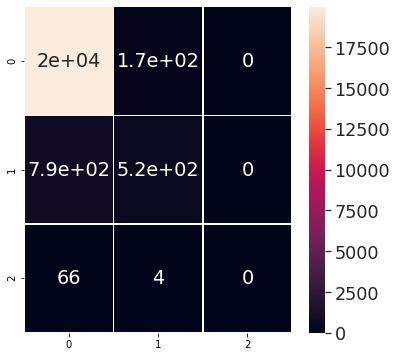

In [ ]:
train_y = pd.DataFrame()
train_y['Lable'] = m
#train_features.drop(['Lable'],axis=1,inplace=True) #you have labels in the training set as well.

train_x = train_features

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.25)


x = X_train.values #returns a numpy array
stdScaler = preprocessing.StandardScaler()
X_train = stdScaler.fit_transform(x)
X_train = pd.DataFrame(X_train)
joblib.dump(stdScaler, scaler_filename) 

#Loading the StdScalar
stdScaler = joblib.load(scaler_filename) 
X_test = stdScaler.transform(X_test)


#Training the Classifier
mymodel=train("RF",X_train,y_train)
acc,test_pred = predict(mymodel,X_test,y_test)
print ("Accuracy = ", acc)
CM_plot(y_test, test_pred)

Accuracy =  0.9399567835961565


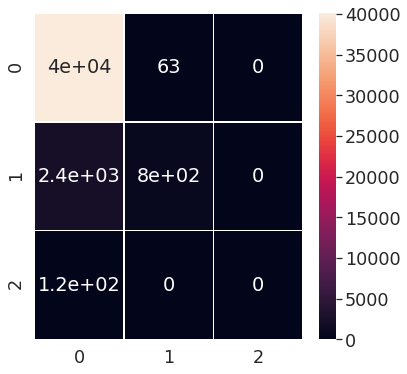

In [ ]:
tst_features = pd.read_excel("/content/drive/MyDrive/DRsegmentation/IP_ML/Training/TestingSet_Exudates.xlsx")
#d_features=d_features.drop(index=0)
tst_features = tst_features.iloc[: , 1:]
tst_lable = tst_features['Lable']
tst_features=tst_features.drop(columns="Lable")

tst = tst_features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
tst_x = min_max_scaler.fit_transform(tst)
tst_x = pd.DataFrame(tst_x)
acc,test_pred = predict(mymodel,tst_x,tst_lable)
print ("Accuracy = ", acc)
CM_plot(tst_lable, test_pred)

In [ ]:
def segment(img):
  segmented_img=extract_RedLesions(img)
  segmented_img=candidates_extraction_for_inference(mymodel,img,segmented_img)
  plot(segmented_img)

  return segmented_img
ig= cv2.imread('/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TestingSet/IDRiD_69.jpg')
segment(ig)

In [ ]:
filename = '/content/drive/MyDrive/DRsegmentation/IP_ML/Training/red_RF_model.sav'
#pickle.dump(mymodel, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
acc,test_pred = predict(loaded_model,X_test,y_test)
print ("Accuracy = ", acc)
